# Impact of multivalency in the formation of cellular membrane-less organells

### Introduction: 

Despite being microscopic, cells are very complex structures. In the cells we find smaller structures, called organelles, which are necessary to maintain normal functionality and life cycle. A common feature of many of these organelles is that they are surrounded by a membrane. Not all organelles are like this. Many organelles exist without a membrane, and the purpose of this project is to study some of the conditions needed to form these structures.

This project mainly addresses two important conditions in the formation of membrane-free organelles. These are electrostatic interactions between monomers, combined with the fact that physical systems seek the lowest possible energy. This is focused on using Monte Carlo simulations, more specifically, the Metropolis algorithm.

In [1]:
"""""""""
Importing libraries.
"""""""""

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from textwrap import wrap
%matplotlib inline


In [2]:
"""""""""
We want to save results from the Monte Carlo simulations we run in npz files. 
The creation and storage of these files takes place inside the Monte Carlo method itself.
This feature is used to delete old results.
"""""""""

def remove_old_files():
    files = os.listdir(".")
    for file in files:
        if file.endswith(".npz"):
            os.remove(file)
            

# uncomment this line to remove outdated numpy files
# remove_old_files()

# Monomers

We start by looking at a simple system, a system consisting of only monomers in a solvent. Later, we will look at more complex systems where we assemble these monomers into larger units, namely polymers.

But first, let's define our modeling system. The monomers are placed on a $N \times N$ grid, and to remove the edge conditions, we will use periodic boundary conditions, where the points to the right of the rightmost column are the leftmost column, and points south of the bottom row, is the top row. This is similar to the surface of a torus.

In [3]:
"""""""""
Setting system parameters
"""""""""

rel_per = 78  # relative permittivity epsilon_r
distance_grid = 23e-6  # distance between two grid points
vacuum_per = 8.85e-12  # Vacuum permittivity
electron = 1.602e-19  # Electron charge
boltzmann = 1.381e-23  # Boltzmanns constant
alpha = electron**2/(4*np.pi*vacuum_per*rel_per*distance_grid**2)
N = 15  # grid size
M = 25  # number of positive / negative monomers


### 1a)

The system of monomers is represented by a randomly generated NxN grid, with periodic boundary conditions. The grid consists of $2M$ monomers, where M are positively charged and M are negatively charged. 

In [4]:

@njit
def random_pos_sample(N, M):
    """Creates a grid of size NxN with 2M monomers, half negatively charged, half positively charged

    Args:
        N (int): size of grid
        M (int): number of positive/negative monomers

    Returns:
        np.ndarray: The grid with randomly set monomers
    """
    grid = np.zeros((N, N), dtype=np.int32)
    for i in range(2*M):
        x, y = np.random.randint(0, N, size=2)
        while grid[x, y]:
            x, y = np.random.randint(0, N, size=2)

        grid[x, y] = 1 if i < M else -1
    return grid


@njit
def set_grid_monomers(N, M=0):
    """Creates a grid of size NxN with 2M monomers

    Args:
        N (int): size of grid
        M (int, optional): number of positive/negative monomers. Defaults to 0.

    Raises:
        ValueError: If there are too many monomers to create grid

    Returns:
        np.ndarray: The grid with randomly set monomers
    """
    if M > N*N / 2:
        raise ValueError("Too many monomers for grid")
    grid = random_pos_sample(N, M)
    return grid


set_grid_monomers(3, 1)
print("Compiled")

Compiled


### 1 b)

We will now visualize our monomer grid. Note that we have both negativly and positivly charged monomers in the plot. We choose to differentiate between these by assigning them different numerical values. 

Positivly charged monomers are set to be equal to 1 (blue)

Negative charged monomers are set to be equal to -1 (red)

In [5]:
monomer_grid = set_grid_monomers(N, M)
print(monomer_grid)

[[-1  0 -1 -1  1  0  0  0 -1  0  0  0  0  0 -1]
 [ 0  0  0  0  0  1  0  1  0  0  0  0  0 -1  0]
 [ 0  0  0  1  0  0  0  0  0  0 -1  1  0  0  0]
 [ 0  0 -1  0  0  0  0  1  0  0 -1  0  0  0  0]
 [ 0  0  0 -1  0 -1  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  1  0  0  0  0  0  0  0]
 [ 1  0 -1  0  0  0  0  0  0  0 -1  1  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  1  0  0  0 -1  0]
 [ 1  0  0  0 -1  0  0  0  0  0  0  0  1 -1  0]
 [ 0  0 -1  0  0  0  0  0  0  1  0 -1  0  0 -1]
 [ 0  1  0  0  1  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 -1  0  1  1  0  0]
 [ 0  0 -1 -1  0 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 -1  1  0  0  0  0]]


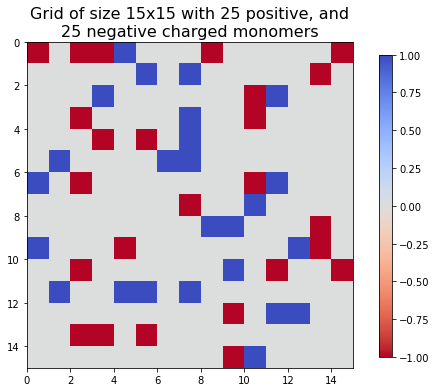

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
mesh = ax.pcolormesh(monomer_grid, cmap="coolwarm_r")
ax.invert_yaxis()
ax.set_title("\n".join(wrap(f'Grid of size {N}x{N} with {M} positive, and {M} negative charged monomers', 40)), size=16)
ax.set_aspect('equal')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
plt.show()

### 1 c)

We are going to need a way to pinpoint the monomers, as well as their neighbours, in the grid. We will now therefore define functions needed to do this.


In [7]:
@njit
def grid_scan(grid):
    """Find all monomers in grid

    Args:
        grid (np.ndarray): grid to search

    Returns:
        list[tuple[int, int]]: list of the location of all monomers
    """
    ind = np.argwhere(grid)
    return list(zip(ind[:, 0], ind[:, 1]))


@njit
def four_neighbours(N, p):
    """Returns the four nearest neighbours to point p

    The grid is assumed to be looping such that the right-most column borders the left-most column, and top borders bottom

    Args:
        N (int): size of the NxN grid
        p (tuple[int, int]): point to find neighbours of

    Raises:
        ValueError: If the point does not have 4 unique neighbours

    Returns:
        list[tuple[int, int]]: The 4 neighbours to this point
    """
    if N < 3:
        raise ValueError("N must be at least equal to 3")
    return [((p[0]+1) % N, p[1]), ((p[0]-1) % N, p[1]), (p[0], (p[1]+1) % N), (p[0], (p[1]-1) % N)]


grid_scan(set_grid_monomers(3, 1))
four_neighbours(3, (0, 0))
print("Compiled")


Compiled


### 1 d)

Energy is a key factor in all physical systems. The energy in this system is simplified to consist of only those energy contributions contributed by electrostatic interactions between adjacent (not diagonal) monomers, and they are calculated using Coulomb's law. In reality, there will be an electrostatic interaction between all monomers in the system, regardless of distance, though as the energy contributions decrease in accordance with the inverse square law, and the solvent screens the electric fields emitted from the monomers, this simplification results in a relativly minor error. We will here implement functions that calculates the total energy in the grid.

In [8]:
@njit
def energy_contribution(grid, N, point):
    """Calculates the energy contribution of a single monomer

    Args:
        grid (np.ndarray): NxN grid of monomers
        N (int): size of grid
        point (tuple[int, int]): monomer to calculate energy contribution of

    Returns:
        float: energy contribution of monomer
    """
    contrib = 0.
    for nb in four_neighbours(N, point):
        contrib += np.sign(grid[point]) * np.sign(grid[nb])
    return contrib * alpha


@njit
def total_energy(grid):
    """Calculates the total energy in a grid of monomers

    Args:
        grid (np.ndarray): NxN grid of monomers

    Returns:
        float: total energy of grid
    """
    N = len(grid)
    energy = 0.
    points = grid_scan(grid)
    for point in points:
        energy += energy_contribution(grid, N, point)
    return 0.5 * energy


total_energy(set_grid_monomers(3, 1))
print("Compiled")


Compiled


In [9]:
total_energy_of_grid = total_energy(monomer_grid)

print(f'The energy of the system is: {total_energy_of_grid:.1e} Joules')

The energy of the system is: 2.8e-20 Joules


### 1 e)

The Monte Carlo method is a numerical method that may simulate the behavior of a system iterativly, and if the number of iterations is large enough then, by the law of averages, we hope to reach some stable equilibrium. And if we by chance don't reach a stable equilibrium, and the amount of iterations is sufficiently high, then that would possibly imply that such an equilibrium does not exist. We may in this way gain useful insight about a system without actually having to delve into the analytical math behind it, which is especially useful when such mathematics is difficult to interprete, or doesn't exist. 

Here we want to define the Monte Carlo method, or more specifically, the Metropolis algorithm. In order to do this we must first define a function that moves monomers in the grid randomly. We may then use this function a set amount of times, and the resulting grid may then be analyzed.

In [10]:
@njit
def move(grid: np.ndarray, N, M, T, points: list, direction):
    """Attempts to move a random monomer in a given direction
    
    The grid and points list are modified in-place

    Args:
        grid (np.ndarray): NxN grid of monomers
        N (int): size of grid
        M (int): number of positive/negative monomers
        T (float): Temperature the monomers are subjected to
        points (list[tuple[int, int]]): a list of all monomer positions in grid
        direction (int): Direction of move [0, 1, 2, 3] -> [right, left, down, up]

    Raises:
        ValueError: If direction is out of bounds

    Returns:
        float: Change in energy
    """
    beta = 1./(boltzmann*T)

    random_index = np.random.randint(0, 2*M)
    random_monomer = points[random_index]

    if direction < 0 or direction > 3:
        raise ValueError("Illegal direction")

    yoff, xoff = ((0, 1), (0, -1), (1, 0), (-1, 0))[direction]

    move_to = ((random_monomer[0]+yoff) % N, (random_monomer[1]+xoff) % N)

    if grid[move_to]:  # Illegal move
        return 0.

    old_contribution = energy_contribution(grid, N, random_monomer)

    charge = grid[random_monomer]
    grid[move_to] = charge
    grid[random_monomer] = 0.

    new_contribution = energy_contribution(grid, N, move_to)

    delta_E = new_contribution - old_contribution

    if delta_E <= 0 or random.random() <= np.exp(-beta*delta_E):
        # updates points with moved point
        points[random_index] = move_to
        return delta_E
    else:
        # revert change
        grid[random_monomer] = charge
        grid[move_to] = 0.
        return 0.


@njit
def MonteCarlo(N_s, N, M, T, grid: np.ndarray):
    """Runs the Metropolis algorithm on the input grid

    Args:
        N_s (int): Total number of iterations
        N (int): size of the input grid
        M (int): number of positive/negative monomers
        T (float): Temperature the monomers are subjected to
        grid (np.ndarray): NxN grid with 2M monomers

    Returns:
        tuple[np.ndarray, np.ndarray]: The resulting grid and energy at each iteration
    """

    result = grid
    E = np.zeros(N_s+1)

    E[0] = total_energy(result)
    points = grid_scan(result)

    for i in range(N_s):
        direction = np.random.randint(0, 4)
        delta_E = move(result, N, M, T, points, direction)
        E[i + 1] = E[i] + delta_E
    return result, E


MonteCarlo(20, 4, 2, 200, set_grid_monomers(4, 2))
print("Compiled")


Compiled


### 1 f)

We run two simulations of 50,000 iterations, with 15x15 grids consisting of 50 monomers. The only thing that varies in the two runs is the temperature, where one has a temperature of 200K and the other of 500K. The runs give different results that are worth discussing. 

In [11]:
def plot_result(result, T, E, iterations):
    """Plots the result of a Monte Carlo simulation

    Args:
        result (np.ndarray): The resulting grid
        T (float): Temperature the monomers are subjected to
        E (np.ndarray): Energy at each iteration
        iterations (int): Number of iterations
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    mesh = ax1.pcolormesh(result, cmap="coolwarm_r")
    ax1.set_title("\n".join(wrap(f"Monomer configuration after {iterations} iterations, at temperature {T}K", 40)), size=16)
    ax1.invert_yaxis()
    ax1.set_aspect('equal')
    
    ax2.plot(np.arange(len(E)), E)
    ax2.set_title("Energy at each iteration", size=16)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Energy")
    ax2.grid(True)
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
    fig.colorbar(mesh, cax=cbar_ax)
    plt.show()


def get_file_name(T):
    """Retrieves a filename for a Monte Carlo simulation at a given temperature

    Args:
        T (float): Temperature the monomers are subjected to

    Returns:
        str: The filename
    """
    return f"T={T:.1f}.npz"


def save_result(result, T, E):
    """Saves the result after a Monte Carlo simulation, namely the resulting grid and each energy level

    Args:
        result (np.ndarray): The resulting grid
        T (float): Temperature the monomers are subjected to
        E (np.ndarray): Energy at each iteration
    """
    np.savez(get_file_name(T), result=result, E=E)


def load_result(T):
    """Retrieves the results after a Monte Carlo simulation, namely the resulting grid and each energy level

    Args:
        T (float): Temperature the monomers are subjected to

    Returns:
        tuple[np.ndarray, np.ndarray]: The resulting grid and energy at each iteration
    """
    file = np.load(get_file_name(T))
    return file["result"], file["E"]

Starting state:


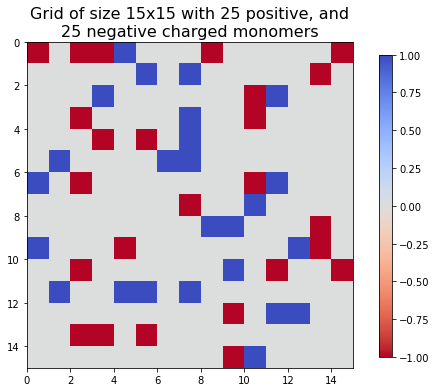

The energy of the system is: 2.8e-20 Joules

Results: 

Result for run at 200 K:


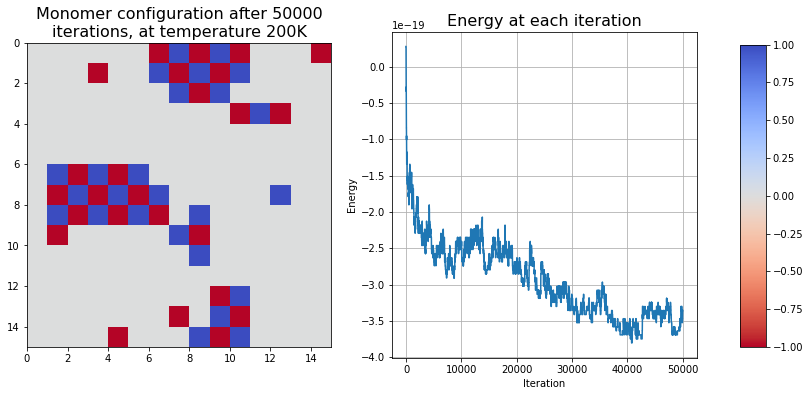

The energy of the system is: -3.4e-19 Joules

Result for run at 500 K:


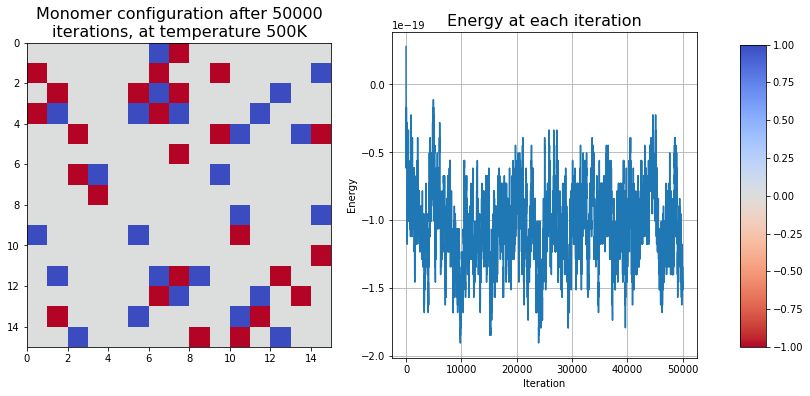

The energy of the system is: -1.5e-19 Joules


In [12]:
print(f'Starting state:')
total_energy_monomer_grid = total_energy(monomer_grid)
fig, ax = plt.subplots(figsize=(6, 6))
mesh = ax.pcolormesh(monomer_grid, cmap="coolwarm_r")
ax.invert_yaxis()
ax.set_title("\n".join(wrap(f'Grid of size {N}x{N} with {M} positive, and {M} negative charged monomers', 40)), size=16)
ax.set_aspect('equal')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(mesh, cax=cbar_ax)

plt.show()

print(f'The energy of the system is: {total_energy_monomer_grid:.1e} Joules')

print("\nResults: ")

for T in (200, 500):
    print(f'\nResult for run at {T} K:')
    result, E = MonteCarlo(50_000, N, M, T, monomer_grid.copy())
    save_result(result, T, E)
    plot_result(result, T, E, 50_000)
    total_energy_grid_temp = total_energy(result)
    print(f'The energy of the system is: {total_energy_grid_temp:.1e} Joules')


Running the monte carlo method at a temperature equal to 200K gives significantly bigger cluster formations than running it at 500K. Thus implying that lower temperature systems tend to more order than higher temperature systems, in the sense that they tend towards an energy minimum. In fact, the 500K system seems to be indifferent to different energy levels, and appear about as chaoic at the end of the simulation as it appeared before the simulation. The reason for the discrepancy can be seen from the monte carlo function to be because lower temperature causes unfavorable moves (moves resulting in greater energy) to become rarer. Thus the lower temperature system will easier tend towards an energy minimum.

Both systems have unstable equilibriums, but visualy we would say that the 500K quickly reaches an equilibrium, after about 5000-10000 iterations, and oscillates pseudo-periodicly between 0.0 and -0.2 aJ, whilst the 200K system is still decreasing in energy after 50000 iterations, but appears to be close to an equilibrium. The major difference in the times to reach equilibrium could be explained by the lower energy at 200 K. It is there harder for the algorithm to perform an unfavorable move, and thus easily gets stuck at local energy minima, instead of moving towards a global minimum

### 1 g)

We will now turn our attention to the formation of aggregates, that is, the clustering
of monomers. We define a cluster of monomers as a group of monomers where there
exists a continuous path between any monomer belonging to the group.

In [13]:
@njit
def find_cluster(p, N, grid, cluster_grid, clusterID=1):
    """Finds all points in the same cluster as p in grid

    Args:
        p (tuple): Initial point
        N (int): Size of grid and cluster_grid should be NxN
        grid (np.ndarray): Grid to find clusters in
        cluster_grid (np.ndarray): Grid to store found clusters
        clusterID (int, optional): The ID of the current cluster. Defaults to 1.

    Raises:
        ValueError: If cluster ID is too low or the initial point is not a monomer
    """
    if clusterID < 1:
        raise ValueError("clusterID is too low, 1 is lowest allowed")
    if not grid[p]:
        raise ValueError("Given point is not a monomer")
    # DFS to find cluster
    stack = [p]
    while stack:
        point = stack.pop()
        if cluster_grid[point]:
            continue
        # Set the ID in the cluster-grid
        cluster_grid[point] = clusterID
        neighbors = four_neighbours(N, point)
        for nb in neighbors:
            if grid[nb] and not cluster_grid[nb]:
                # This is an undiscovered point
                stack.append(nb)


@njit
def grid_to_cluster(grid: np.ndarray):
    """Finds all clusters in grid, and returns array containing a unique ID for each cluster

    Args:
        grid (np.ndarray): Grid to find clusters in

    Returns:
        tuple[np.ndarray, int]: Cluster grid, number of clusters
    """
    cluster_grid = np.zeros_like(grid, dtype=np.int32)
    N = len(grid)
    id = 0
    for x in range(N):
        for y in range(N):
            if grid[x, y] and not cluster_grid[x, y]:
                # This is an undiscovered point
                id += 1
                find_cluster((x, y), N, grid, cluster_grid, clusterID=id)

    return cluster_grid, id


@njit
def create_cluster_grid(grid):
    """Greates a cluster grid from the input grid, where two monomers are defined to be in the same cluster if there exists a countinous path between them
    
    The resulting array will have a unique ID for each cluster

    Args:
        grid (np.ndarray): grid to find clusters in

    Returns:
        tuple[np.ndarray, int]: Cluster grid, number of clusters
    """
    cluster_grid, num_clusters = grid_to_cluster(grid)
    return cluster_grid, num_clusters


create_cluster_grid(set_grid_monomers(3, 2))
print("Compiled")


Compiled


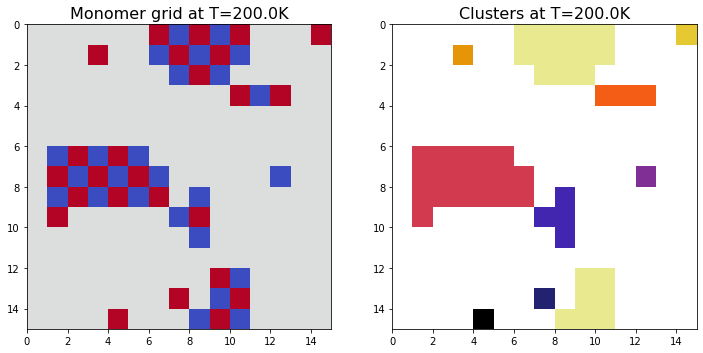

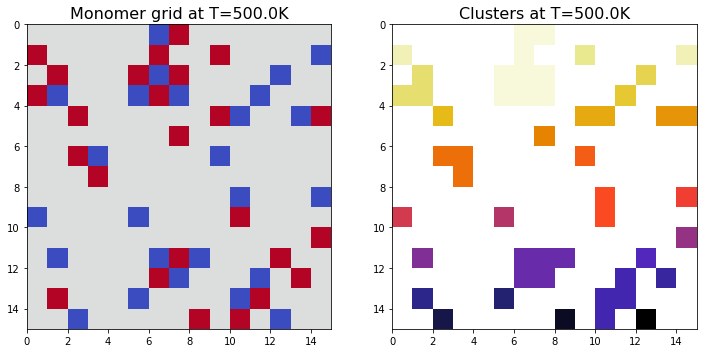

In [14]:
def plot_cluster():
    """Plots the clusters in the result from a Monte Carlo simulation
    """
    T_low = 200
    T_high = 500

    for T in [T_low, T_high]:
        result, E = load_result(T)
        cluster_grid, num_clusters = create_cluster_grid(result)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.pcolormesh(result, cmap="coolwarm_r")
        ax1.set_title(f"Monomer grid at T={T:.1f}K", size=16)
        ax1.invert_yaxis()
        ax1.set_aspect('equal')

        result, E = load_result(T)
        cluster_grid, num_clusters = create_cluster_grid(result)
        ax2.pcolormesh(cluster_grid, cmap="CMRmap_r")
        ax2.set_title(f"Clusters at T={T:.1f}K", size=16)
        ax2.invert_yaxis()
        ax2.set_aspect('equal')


plot_cluster()


On the left we find the systems that resulted from the Monte Carlo simulation in 1f. And on their right we find their corresponding cluster configurations. The cluster grid is colour coded to separate the different clusters. Note that the color no longer gives any information about the charge any given monomer has, and that the white colour refers to the lack of a monomer, as such it may be considered the solvent the monomers are in.

## 1h)




In [15]:
"""""""""
Setting system parameters
"""""""""

T_l = 100  # lower temperature limit
T_h = 1000  # upper temperature limit
N = 15  # grid size
M = 25  # number of positive / negative monomers
t_max = 1_000_000  # upper time limit
s = 1./200  # constant to calculate t_equilibrium
C = 10_000  # arbitrary constant
t_r = 1000  # iterations between measurements
num_measurements = 1000  # number of measurements after equilibrium


In [16]:
def t_equil(T):
    """Takes an educated guess at how many iterations are needed to reach equilibrium

    Args:
        T (float): Temperature the monomers are subjected to

    Returns:
        int: Number of iterations until equilibrium
    """
    return int(t_max*np.exp(-s*(T - T_l)) + C)


def MC_mean_cluster_size(N, M, T, grid):
    """Runs the Monte Carlo algorithm to get an imperical average of the cluster size
    
    The algorithm is ran for t_equil steps to reach equilibrium, then the cluster size is measured num_measurements times, with t_r iterations between each

    Args:
        N (int): size of the grid
        M (int): number of positive/negative monomers
        T (float): Temperature the monomers are subjected to
        grid (np.ndarray): NxN grid of monomers

    Returns:
        tuple[float, float]: The mean cluster size and the standard deviation
    """
    t = t_equil(T)
    result, _ = MonteCarlo(t, N, M, T, grid)
    clusters = np.zeros(num_measurements)
    for i in range(num_measurements):
        result, _ = MonteCarlo(t_r, N, M, T, result)
        _, num_clusters = create_cluster_grid(result)
        clusters[i] = num_clusters

    mean_cluster_size = (2*M * num_measurements) / np.sum(clusters)
    standard_deviation = np.sqrt(sum(map(lambda x: ((2*M/x) - mean_cluster_size)**2, clusters))/(num_measurements-1))
    return mean_cluster_size, standard_deviation

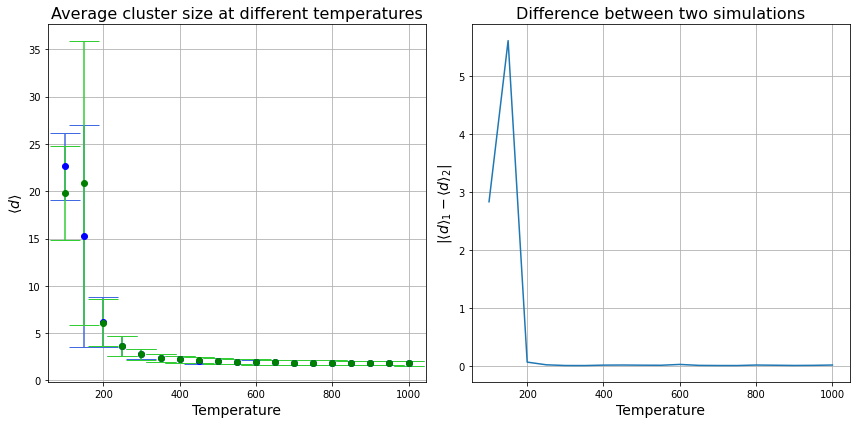

In [19]:
def mean_cluster_size(temperatures):
    """Uses MC_mean_cluster_size to calculate the average cluster size at different temperatures

    Args:
        temperatures (np.ndarray): Temperatures the monomers are subjected to

    Returns:
        tuple[np.ndarray, np.ndarray]: Array of the corresponding mean cluster sizes and array of corresponding standard deviations
    """
    d = np.zeros_like(temperatures, dtype=np.float64)
    stddiv = np.zeros_like(temperatures, dtype=np.float64)
    for i, temp in enumerate(temperatures):
        grid = set_grid_monomers(N, M)
        d[i], stddiv[i] = MC_mean_cluster_size(N, M, temp, grid)
    return d, stddiv


temperatures = np.linspace(T_l, T_h, 19)
d1, stddiv1 = mean_cluster_size(temperatures)
d2, stddiv2 = mean_cluster_size(temperatures)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.errorbar(temperatures, d1, stddiv1, label=1, fmt='o', capsize=15, color = "blue", ecolor="royalblue")
ax1.errorbar(temperatures, d2, stddiv2, label=2, fmt='o', capsize=15, color = "green", ecolor="limegreen")
ax1.set_title("Average cluster size at different temperatures", size=16)
ax1.set_xlabel("Temperature", size=14)
ax1.set_ylabel("$\\langle d\\rangle$", size=14)
ax1.grid(True)

ax2.plot(temperatures, np.abs(d1-d2))
ax2.set_title("Difference between two simulations", size=16)
ax2.set_xlabel("Temperature", size=14)
ax2.set_ylabel("$|\\langle d\\rangle_1 - \\langle d\\rangle_2|$", size=14)
ax2.grid(True)
plt.tight_layout()
plt.show()

As we can see the clustersizes tend to decrease when the temperature increases. This implies that lower temperatures tend to become less chaotic over time. We also see that the variance between two simulations starts off somewhat high, and then decreases with increasing temperatures. This implies that the systems at low temperatures do not reach a true equilibrium before measurements begin and/or the number of iterations between each measurement is too low for the measurements to be independent. At such low temperatures, it is harder for the algorithm to make an energetically unfavourable move, thus the system could get stuck at local energy minima, and never truly make it towards the global minimum. At these temperatures, the starting positions, and initial movements are of such importance for which local energy minima it will get stuck in, that even after 2 million iterations, the results are heavyly biased. 

If the algorithm was run for even magnitudes greater iterations, it would inevitably get more consistent, but these scales are too massive to truly handle. Since 1000 iterations are not enough to get to a new independent state at these temperatures, the number of iterations between measurements would also have to be increased drastically to get an accurate average

The number of measurements is set to 1000, because it allows for reliable results in reasonable time. The results at low temperatures are caused by other factors than the coice of measurement-count, e.g. itertion count between measurements, and the factors mentioned above. If the 1000 results were truly independent, the deviation should be irrelevant.

# Polymers

With our knowledge of monomers, we will now turn our attention to the formation of polymers. We will look at how the introduction of
monomer connectivity (i.e. covalent bonds between monomers) affect aggregate formation/clustering. 

In [20]:
"""""""""
Setting system parameters
"""""""""

rel_per = 78  # relative permittivity epsilon_r
distance_grid = 91e-6  # distance between two grid points
vacuum_per = 8.85e-12  # Vacuum permittivity
electron = 1.602e-19  # Electron charge
boltzmann = 1.381e-23  # Boltzmanns constant
alpha = electron**2/(4*np.pi*vacuum_per*rel_per*distance_grid**2)
N_s = 30_000
N = 20  # grid size
M = 4  # number of positive / negative monomers
L = 21  # number of monomers in a polymer


### 2a)

The system of polymers is represented by a randomly generated NxN grid, with periodic boundary conditions. The grid consists of $2\cdot M$ polymers, where M are positively charged and M are negatively charged. In addition to 1a), here we specify the length L of the polymer. The length L is then in other words the number of monomers bound together. 

In [21]:
@njit
def generate_set_of_all_possible_positions(grid):
    """Generates set of all possible locations in the grid

    Args:
        grid (np.ndarray): grid of size NxN

    Returns:
        set[tuple[int, int]]: Set of all coordinates in grid
    """
    return set([(x, y) for x in range(len(grid)) for y in range(len(grid))])


@njit
def generate_polymer(grid, N, L, all_possible_positions, charge):
    """Generates a polymer of size L in the grid, where the polymer is continous

    Args:
        grid (np.ndarray): grid of size NxN
        N (int): size of grid
        L (int): number of monomers in the polymer
        all_possible_positions (set[tuple[int, int]]): Set of all legal remaining positions in the grid
        charge (int): functions as a way of identifing the generated polymer later, whilst the sign decides the actual charge of the polymer

    Raises:
        ValueError: If there is nowhere in the grid to fit a L long continous polymer

    Returns:
        set[tuple[int, int]]: The updated legal positions, after adding itself to the grid
    """
    all_possible_list = list(all_possible_positions)
    if not all_possible_list:
        raise ValueError("Could not place all polymers on grid")
    monomer = all_possible_list[np.random.randint(len(all_possible_list))]
    polymer = {monomer}
    full_monomer = {monomer}
    full_monomer.pop()  # Needed for numba to determine type
    for _ in range(L-1):
        while True:
            possible_pos = list(polymer - full_monomer)
            if not possible_pos:
                # Not enough space for polymer here, try again
                return generate_polymer(grid, N, L, all_possible_positions - polymer, charge)

            monomer = possible_pos[np.random.randint(len(possible_pos))]
            monomer_neighbours = four_neighbours(N, monomer)
            legal_neighbours = set(monomer_neighbours).intersection(all_possible_positions) - polymer

            if not legal_neighbours:
                full_monomer.add(monomer)
            else:
                legal_neighbour_list = list(legal_neighbours)
                monomer = legal_neighbour_list[np.random.randint(len(legal_neighbour_list))]
                polymer.add(monomer)
                break

    for monomer in polymer:
        grid[monomer] = charge
    return all_possible_positions - polymer


@njit
def set_grid_polymer(N, M=0, L=1):
    """Generates 2M non-overlapping, L long polymers, with evenly distributed charge
    
    Half of the polymers are negatively charged, the other half positive

    Args:
        N (int): size of the grid
        M (int, optional): number of positive/negative polymers. Defaults to 0.
        L (int, optional): Length of each polymer. Defaults to 1.

    Raises:
        ValueError: If L is non-positive or there is not enough space on the grid for the polymers

    Returns:
        np.ndarray: The generated grid of polymers
    """
    if L < 1:
        raise ValueError("Illegal polymer length")
    if M * L > N*N / 2:
        raise ValueError("Too many monomers for grid")
    grid = np.zeros((N, N), dtype=np.int32)  # defining N x N grid
    all_possible_positions = generate_set_of_all_possible_positions(grid)
    for i in range(2*M):
        all_possible_positions = generate_polymer(grid, N, L, all_possible_positions, ((i/2 + 1) if i % 2 == 0 else -((i-1)/2 + 1)))

    return grid


set_grid_polymer(5, 2, 3)
print("Compiled")

Compiled


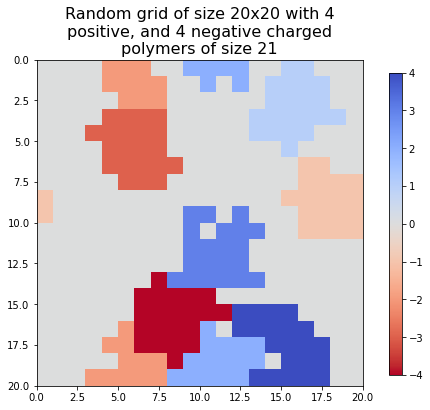

In [23]:
polymer_grid = set_grid_polymer(N, M, L)

fig, ax = plt.subplots(figsize=(6, 6))
mesh = ax.pcolormesh(polymer_grid, cmap="coolwarm_r")
ax.invert_yaxis()
ax.set_title("\n".join(wrap(f'Random grid of size {N}x{N} with {M} positive, and {M} negative charged polymers of size {L}', 40)), size=16)
ax.set_aspect('equal')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(mesh, cax=cbar_ax)

Note that positive polymers are set to positive values (shades of blue), and negative polymers are set to negative values (shades of red). 

### 2b)

We take the same procedure as in task 1c), where only neighbors contribute to the energy function. Another simplification that is done is to put interactions between monomers belonging to the same polymer to zero.

In [24]:
@njit
def energy_contribution_polymer(grid, N, point):
    """Calculates the energy contribution of a single monomer

    Args:
        grid (np.ndarray): NxN grid of polymers
        N (int): size of grid
        point (tuple[int, int]): monomer to calculate energy contribution of

    Returns:
        float: energy contribution of monomer
    """
    contrib = 0.
    for nb in four_neighbours(N, point):
        if grid[nb] != grid[point]:  
            # Limit to interactions between different polymers
            contrib += np.sign(grid[point]) * np.sign(grid[nb])
    return contrib * alpha


@njit
def total_energy_polymer(grid):
    """Calculates the total energy in a grid of polymers

    Args:
        grid (np.ndarray): NxN grid of monomers

    Returns:
        float: total energy of grid
    """
    N = len(grid)
    energy = 0.
    points = grid_scan(grid)
    for point in points:
        energy += energy_contribution_polymer(grid, N, point)
    return 0.5 * energy


total_energy_polymer(set_grid_polymer(5, 2, 2))
print("Compiled")

Compiled


In [25]:
total_energy_polymer_grid = total_energy_polymer(polymer_grid)

print(f'The energy of the system is: {total_energy_polymer_grid:.1e} Joules')

The energy of the system is: 1.1e-21 Joules


### 2c)

Like a monomer, a polymer must also have the ability to move. We will define two ways a polymer can move. We start by defining the simpler movement functionality first, namely where the whole polymer moves as a unit.

Possible directions of movement are: right, left, down and up, which are given the numerical values 0, 1, 2, and 3, respectively.

In [26]:
@njit
def scan_polymers(grid, N, M):
    """Finds all polymers in grid
    
    The polymers are stored as lists of points in a list, where indexes [1,M] are for the corresponding positive charge polymers
    
    and indexes [-1,-M] are for the corresponding negative charge polymers

    Args:
        grid (np.ndarray): Grid of size NxN to scan
        N (int): Size of grid

    Returns:
        list[list[tuple[int, int]]]: list of polymers
    """
    poly_list = [[(0, 0)] for _ in range(2*M+2)]
    for sub in poly_list:  # This is needed for numba to determine type
        sub.pop()

    for x in range(N):
        for y in range(N):
            poly_list[int(grid[x][y])].append((x, y))
    return poly_list


@njit
def move_polymer_rigidly(grid, N, T, polymer_list, poly_nr, move):
    """Attempts to move the entire polymer given by poly_nr one unit in the direction specified by move
    
    The grid and polymer list are modified in-place
    
    (Can only be called by another jitted function, because of some trivialities)

    Args:
        grid (np.ndarray): grid of polymers of size NxN
        N (int): size of grid
        T (float): Temperature the polymers are subjected to
        polymer_list (list[list[tuple[int, int]]]): list of polymers
        poly_nr (int): ID of polymer to move
        move (int): Direction of move [0, 1, 2, 3] -> [right, left, down, up]

    Raises:
        ValueError: If move is out of bounds

    Returns:
        float: Change in energy
    """
    beta = 1./(boltzmann*T)
    polymer = polymer_list[poly_nr]

    if move < 0 or move > 3:
        raise ValueError("Illegal direction")

    yoff, xoff = ((0, 1), (0, -1), (1, 0), (-1, 0))[move]

    new_points = [((point[0] + yoff) % N, (point[1] + xoff) % N) for point in polymer]

    for point in new_points:
        if grid[point] != poly_nr and grid[point] != 0:
            return 0.

    old_contribution = 0.
    for point in polymer:
        old_contribution += energy_contribution_polymer(grid, N, point)
    
    polymer_list[poly_nr] = new_points
    for point in polymer:
        grid[point] = 0
    for point in new_points:
        grid[point] = poly_nr
        
    
    new_contribution = 0.
    for point in new_points:
        new_contribution += energy_contribution_polymer(grid, N, point)
    
    delta_E = new_contribution - old_contribution
    
    if delta_E <= 0 or random.random() <= np.exp(-beta*delta_E):
        # keep the change
        return delta_E
    
    # revert the change
    polymer_list[poly_nr] = polymer
    for point in new_points:
        grid[point] = 0
    for point in polymer:
        grid[point] = poly_nr
    return 0.


@njit
def compile_rigid():
    _grid = set_grid_polymer(5, 2, 2)
    move_polymer_rigidly(_grid, 5, 200, scan_polymers(_grid, 5, 2), 1, 1)


compile_rigid()
print("Compiled")

Compiled


### 2f)

It's important for the simulation that the polymers don't break during movement. We must therefor create a function that checks if a polymer would break given a certain movement so that we may prevent it.

In [27]:
@njit
def broken_polymer(N, polymer_points):
    """Checks whether a polymer is broken

    Args:
        N (int): size of the grid
        polymer_points (list[tuple[int, int]]): The points the polymer consists of

    Returns:
        bool: True if the polymer is broken
    """
    
    # map to store the monomers in this polymer
    # 0: finished, -1: discovered, 1: not discovered yet
    pointMap = {point: 1 for point in polymer_points}
    # BFS from the first point
    queue = np.zeros((len(polymer_points), 2), dtype=np.int64)
    queue[0] = polymer_points[0]
    current, end = 0, 1
    while current < end:
        point = queue[current]
        current += 1
        if pointMap.get((point[0], point[1]), 0) == 0:
            continue
        pointMap[(point[0], point[1])] = 0
        for nb in four_neighbours(N, point):
            # the points are only added to the queue once each
            if pointMap.get(nb, 0) == 1:
                pointMap[nb] = -1
                queue[end] = nb
                end += 1
    
    # If there are any points that were not found by BFS, the polymer is broken
    return end < len(polymer_points)

### 2e)

A more realistic, and complex, way a polymer can move is here refered to as the medium flexibility move. Each monomer belonging to the same polymer row (or column) moves as a single unit. Such that parts of the whole polymer may move even if the entire polymer may not. It is here paramount to verify that a polymer doesn't break before we comit the movement, as the extra flexiblity makes this possible. 

In [31]:
@njit
def polymer_point_to_column(polymer, N):
    """Separates polymer into lists with common y-values

    Args:
        polymer (list[tuple[int, int]]): list of all points in polymer

    Returns:
        list[list[tuple[int, int]]]: The points in polymer, grouped by y-value
    """
    column_polymers = [[(0, 0)] for _ in range(N)]
    for sub in column_polymers:  # This is needed for numba to determine type
        sub.pop()

    for point in polymer:
        column_polymers[point[1]].append(point)
    return column_polymers


@njit
def polymer_point_to_row(polymer, N):
    """Separates polymer into lists with common x-values

    Args:
        polymer (list[tuple[int, int]]): list of all points in polymer

    Returns:
        list[list[tuple[int, int]]]: The points in polymer, grouped by x-value
    """
    row_polymers = [[(0, 0)] for _ in range(N)]
    for sub in row_polymers:  # This is needed for numba to determine type
        sub.pop()

    for point in polymer:
        row_polymers[point[0]].append(point)
    return row_polymers


@njit
def move_polymer_medium_flexibility(grid, N, T, polymer_list, poly_nr, move):
    """Attempts to move a polymer in a specified direction using medium flexible movement, that is
    to say that the polymer is moved column by column, or row by row, allowing the polymer to deform
    after a move.

    The grid and polymer list are modified in-place
    
    (Can only be called by another jitted function, because of some trivialities)

    Args:
        grid (np.ndarray): grid of polymers of size NxN
        N (int): size of grid
        T (float): Temperature the polymers are subjected to
        polymer_list (list[list[tuple[int, int]]]): list of polymers
        poly_nr (int): ID of polymer to move
        move (int): Direction of move [0, 1, 2, 3] -> [right, left, down, up]

    Raises:
        ValueError: If move is out of bounds

    Returns:
        float: Change in energy
    """
    beta = 1./(boltzmann*T)
    polymer = polymer_list[poly_nr]

    if move < 0 or move > 3:
        raise ValueError("Illegal direction")

    yoff, xoff = ((0, 1), (0, -1), (1, 0), (-1, 0))[move]

    if move < 2:
        shared_dir_polymers = polymer_point_to_row(polymer, N)
    else:
        shared_dir_polymers = polymer_point_to_column(polymer, N)

    new_points = []
    for line_polymer in shared_dir_polymers:
        moved_part = [((point[0] + yoff) % N, (point[1] + xoff) % N) for point in line_polymer]
        for point in moved_part:
            if grid[point] != poly_nr and grid[point] != 0:
                # This is an illegal move
                new_points.extend(line_polymer)
                break
        else:
            # This block is executed if the for loop did not reach any breaks (i.e. the move is legal)
            new_points.extend(moved_part)

    if broken_polymer(N, new_points):
        return 0.

    old_contribution = 0.
    for point in polymer:
        old_contribution += energy_contribution_polymer(grid, N, point)

    polymer_list[poly_nr] = new_points
    for point in polymer:
        grid[point] = 0
    for point in new_points:
        grid[point] = poly_nr

    new_contribution = 0.
    for point in new_points:
        new_contribution += energy_contribution_polymer(grid, N, point)

    delta_E = new_contribution - old_contribution

    if delta_E <= 0 or random.random() <= np.exp(-beta*delta_E):
        # keep the change
        return delta_E

    # revert the change
    polymer_list[poly_nr] = polymer
    for point in new_points:
        grid[point] = 0
    for point in polymer:
        grid[point] = poly_nr
    return 0.


@njit
def compile_medium_flexibility():
    _grid = set_grid_polymer(5, 2, 2)
    move_polymer_medium_flexibility(_grid, 5, 200, scan_polymers(_grid, 5, 2), 1, 1)


compile_medium_flexibility()
print("Compiled")

Compiled


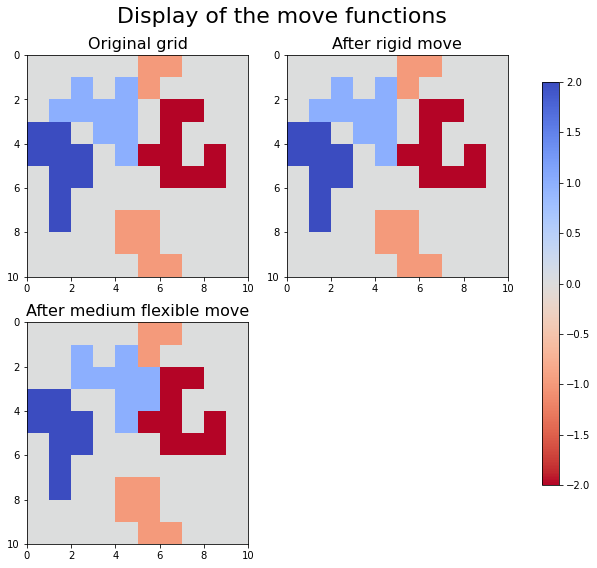

In [32]:
polymer_grid = np.array([[0, 0, 0, 0, 0, -1, -1, 0, 0, 0],
                         [0, 0, 1, 0, 1, -1, 0, 0, 0, 0],
                         [0, 1, 1, 1, 1, 0, -2, -2, 0, 0],
                         [2, 2, 0, 1, 1, 0, -2, 0, 0, 0],
                         [2, 2, 2, 0, 1, -2, -2, 0, -2, 0],
                         [0, 2, 2, 0, 0, 0, -2, -2, -2, 0],
                         [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 2, 0, 0, -1, -1, 0, 0, 0, 0],
                         [0, 0, 0, 0, -1, -1, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, -1, -1, 0, 0, 0]])



@njit
def test_rigid():
    polymer_grid_moved = polymer_grid.copy()
    move_polymer_rigidly(polymer_grid_moved, 10, T, scan_polymers(polymer_grid_moved, 10, 2), 1, 0)
    return polymer_grid_moved


@njit
def test_medium_flexibility():
    polymer_grid_moved = polymer_grid.copy()
    move_polymer_medium_flexibility(polymer_grid_moved, 10, T, scan_polymers(polymer_grid_moved, 10, 2), 1, 0)
    return polymer_grid_moved


rigid_polymer_moved = test_rigid()
medium_flexibility_polymer_moved = test_medium_flexibility()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
mesh = ax1.pcolormesh(polymer_grid, cmap="coolwarm_r")
ax1.invert_yaxis()
ax1.set_title('Original grid', size=16)
ax1.set_aspect('equal')

mesh = ax2.pcolormesh(rigid_polymer_moved, cmap="coolwarm_r")
ax2.invert_yaxis()
ax2.set_title('After rigid move', size=16)
ax2.set_aspect('equal')

mesh = ax3.pcolormesh(medium_flexibility_polymer_moved, cmap="coolwarm_r")
ax3.invert_yaxis()
ax3.set_title('After medium flexible move', size=16)
ax3.set_aspect('equal')

fig.delaxes(ax4)

fig.suptitle("Display of the move functions", size=22)
plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
pass

In the upper left grid we see a preconfigured system of four polymers. In the other grids we see what happens were we to attempt to move polymer -1, that is to say the light blue polymer, to the right.

In the upper right grid the rigid movement function has been employed, and nothing happens. Due to the lower and upper rows of the polymer being blocked by other polymers, a rigid move to the right would cause overlapp between polymers and is therefor forbidden, thus it remains in place.

In the lower left grid the medium flexibility movement function has been employed, causing the second and third rows to move to the right, whilst the upper and lower rows remain in place. Due to the medium flexible movement, the second and third row may move to the right even though the entire polymer may not. This is because we have divided the polymer into row parts, each of which may move rigidly independent of the other row parts. Note that if this had resulted in the polymer breaking, we would be forced to forbidd the move.

### 2d)

We will now design a new Monte Carlo simulation, fit for the new polymer setup. We will run both simulations for rigid and flexible movement. We start with the simpler case, rigid movement. Note that we multiply with L when determining whether a move shall be done, this is done in order to artifically inflate the delta E term, such that they better match the corresponding delta E in the monomer case. 

In [45]:
"""""""""
Setting system parameters
"""""""""

N = 30  # size of grid
L = 30  # number of monomers in a polymer
M = 5  # number of positive / negative monomers
T = 200  # temperature
iterations = 100000  # number of iterations in the Monte Carlo simulations


In [50]:
# initializing a grid which is used for the tasks below

polymer_grid = set_grid_polymer(N, M, L)

In [47]:
@njit
def monte_carlo_polymer(N_s, N, M, T, grid, move_type):
    """Runs the Metropolis algorithm on a grid containing polymers

    Args:
        N_s (int): Total number of iterations
        N (int): size of the input grid
        M (int): number of positive/negative polymers
        T (float): Temperature the polymers are subjected to
        grid (np.ndarray): NxN grid of polymers
        move_type (int): type of movement [0,1] -> ["rigid","medium flexible"]

    Raises:
        ValueError: if move_type is invalid

    Returns:
        tuple[np.ndarray, np.ndarray]: The resulting grid and energy at each iteration
    """
    result = grid.copy()
    E = np.zeros(N_s+1)
    E[0] = total_energy_polymer(result)
    polymer_list = scan_polymers(result, N, M)

    if move_type < 0 or move_type > 1:
        raise ValueError("Invalid move type")

    if move_type == 0:
        for i in range(N_s):
            poly_nr = np.random.randint(1, M + 1)
            if random.random() < 0.5:
                poly_nr = -poly_nr
            move = np.random.randint(4)

            delta_E = move_polymer_rigidly(result, N, T, polymer_list, poly_nr, move)
            E[i+1] = E[i] + delta_E
            
    elif move_type == 1:
        for i in range(N_s):
            poly_nr = np.random.randint(1, M + 1)
            if random.random() < 0.5:
                poly_nr = -poly_nr
            move = np.random.randint(4)

            delta_E = move_polymer_medium_flexibility(result, N, T, polymer_list, poly_nr, move)
            E[i+1] = E[i] + delta_E
            
    return result, E


monte_carlo_polymer(20, 4, 2, 200, set_grid_polymer(4, 2, 2), 1)
print("Compiled")

Compiled


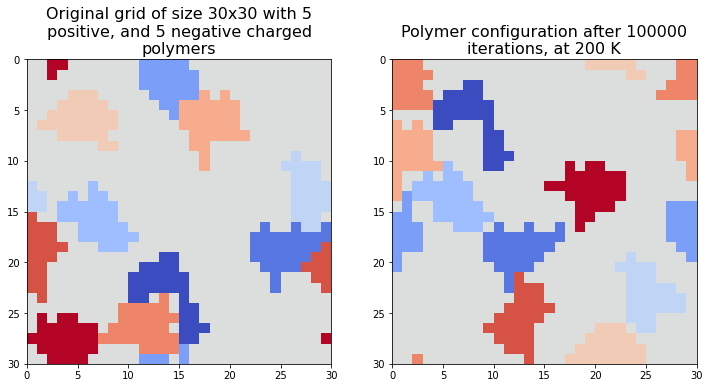

The original grid has an energy of -5.7e-21, whilst the grid after the Monte Carlo simulaion has an energy of -2.1e-21


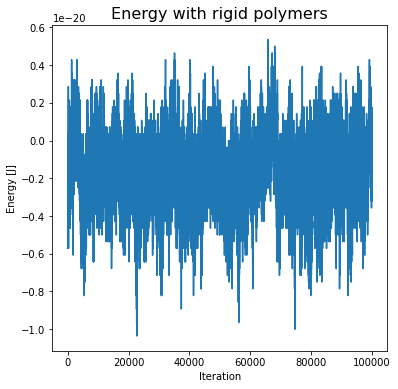

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mesh = ax1.pcolormesh(polymer_grid, cmap="coolwarm_r")
ax1.invert_yaxis()
ax1.set_title("\n".join(wrap(f'Original grid of size {N}x{N} with {M} positive, and {M} negative charged polymers', 40)), size=16)
ax1.set_aspect('equal')

polymer_montecarlo_after_rigid, E_rigid = monte_carlo_polymer(iterations, N, M, T, polymer_grid.copy(), 0)

mesh = ax2.pcolormesh(polymer_montecarlo_after_rigid, cmap="coolwarm_r")
ax2.invert_yaxis()
ax2.set_title("\n".join(wrap(f"Polymer configuration after {iterations} iterations, at {T} K", 40)), size=16)
ax2.set_aspect('equal')
plt.show()
print(f"The original grid has an energy of {E_rigid[0]:.1e}, whilst the grid after the Monte Carlo simulaion has an energy of {E_rigid[-1]:.1e}")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(mesh, cax=cbar_ax)

plt.figure(figsize=(6, 6))
plt.plot(np.arange(len(E_rigid)), E_rigid)
plt.title("Energy with rigid polymers", size=16)
plt.xlabel("Iteration")
plt.ylabel("Energy [J]")
plt.show()

We can see that oppositly charged polymers tend to merge together, though their total border is fairly small, mostly due to their rigidness. Since we are moving entire polymers at a time, we expect a shorter amount of required iterations to reach equilibrium, than in the monomer case. 

The initial grid usually seems to be more clumped together than the grid at equilibrium. This makes sense, as the polymers were generated to fit next to each other, but after they have moved around a lot, it is hard for the rigid bodies to intertwine with each other again, thus the initial grid has lower energy thatn at equilibrium

### 2g)

We will now run the Monte Carlo simulation again, this time using the medium flexibility function.

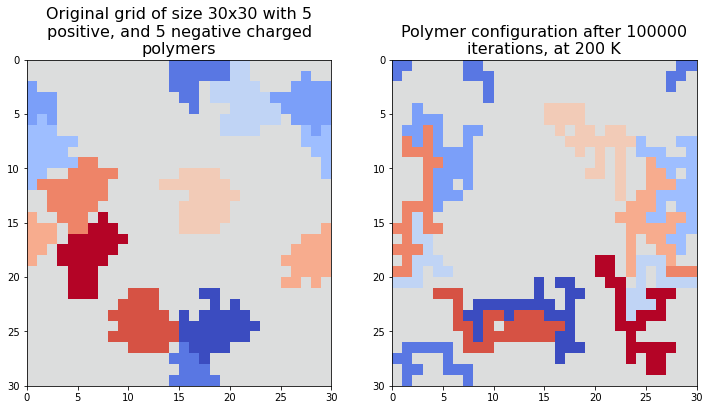

The original grid has an energy of 6.8e-21, whilst the grid after the Monte Carlo simulaion has an energy of -3.4e-20


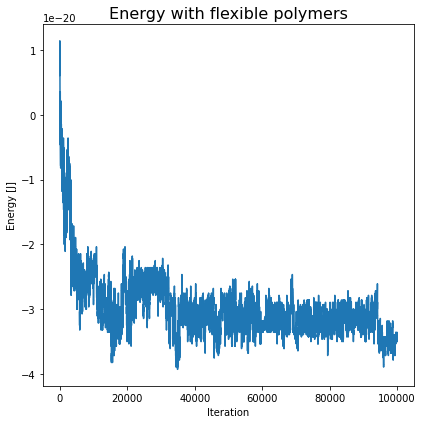

In [52]:
# Running montecarlo

polymer_montecarlo_flexible_original = set_grid_polymer(N, M, L)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mesh = ax1.pcolormesh(polymer_montecarlo_flexible_original, cmap="coolwarm_r")
ax1.invert_yaxis()
ax1.set_title("\n".join(wrap(f'Original grid of size {N}x{N} with {M} positive, and {M} negative charged polymers', 40)), size=16)
ax.set_aspect('equal')   

polymer_montecarlo_flexible_after, E_flexible = monte_carlo_polymer(iterations, N, M, T, polymer_montecarlo_flexible_original.copy(), 1)

mesh = ax2.pcolormesh(polymer_montecarlo_flexible_after, cmap="coolwarm_r")
ax2.invert_yaxis()
ax2.set_title("\n".join(wrap(f"Polymer configuration after {iterations} iterations, at {T} K", 40)), size=16)
ax.set_aspect('equal') 
plt.show()
print(f"The original grid has an energy of {E_flexible[0]:.1e}, whilst the grid after the Monte Carlo simulaion has an energy of {E_flexible[-1]:.1e}")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(mesh, cax=cbar_ax)

plt.figure(figsize=(6, 6))
plt.plot(np.arange(len(E_rigid)), E_flexible)
plt.title("\n".join(wrap("Energy with flexible polymers", 40)), size=16)
plt.xlabel("Iteration")
plt.ylabel("Energy [J]")
plt.tight_layout()
plt.show()

There are obviously major changes after running 100,000 iterations of the Monte Carlo method. The most obvious difference between rigid move and medium flexibility move is the shape of the polymers at the end state. Due to the nature of rigid moves, the polymers do not change shape or orientation after the simulation. With medium flexibility moves however, the polymers become more elongated after the simulation.

When comparing the results from 2d and 2g we see that the polymers end up in far more intertwined positions. It is furthermore implied by the graphs, that longer borders between oppositly charged polymers cause a greater decrease in the total energy of the system, compared to isolated polymers. This further tells us a reason why the energy in the rigid case is greater, namly due to the rigid systems inability to create intertwined polymer clusters.


## 2h)

In [53]:
"""""""""
Setting system parameters
"""""""""

T = 300  # Temperature
t_r = 1000  # Monte Carlo check step
t_max = 100_000  # upper time limit
s = 1/200  # constant to calculate t_equilibrium
N = 30  # grid size
M = 5  # number of positive / negative polymers
L_low = 3  # lower length limit
L_high = 39  # upper length limit
# equal partition of 13 points between upper and lower length bound
L_nodes = np.linspace(L_low, L_high, 13)
C = 5_000  # arbitrary constant
num_measurements = 50  # number of measurements after equilibrium


In [54]:
# @njit
def t_equill(N, M, L):
    """Calculates the desired amount of iterations in order to hopefully reach equilibrium
    
    C is a margin of error, t_equill should be larger for larger grids and smaller if there are many polymers

    Args:
        N (int): size of grid
        M (int): number of positive/negative polymers
        L (int): length of each polymer

    Returns:
        int: Amount of iterations to reach equlibrium
    """
    return int(t_max * np.exp(-s*(L-L_low)*2*M/N**2) + C)


# @njit
def mean_cluster_size_and_number(N, M, L, T, grid):
    """Calculates the mean cluster size divided by L and the average number of clusters with a given grid
    
    The Monte Carlo algorithm is ran for t_equill steps to reach equilibrium, then the cluster size is measured num_measurements times, with t_r iterations between each
    
    Args:
        N (int): size of grid
        M (int): number of positive/negative polymers
        L (int): length of each polymer
        T (float): Temperature the polymers are subjected to
        grid (np.ndarray): NxN grid containing M L-length polymers

    Returns:
        tuple[float, float, float, float]: mean cluster size divided by L, and its stddiv and average number of cluster and its stddiv
    """
    t = t_equill(N, M, L)
    result, _ = monte_carlo_polymer(t, N, M, T, grid, 1)
    clusters = np.zeros(num_measurements, dtype=np.float64)
    for i in range(num_measurements):
        result, _ = monte_carlo_polymer(t_r, N, M, T, result, 1)
        _, num_clusters = create_cluster_grid(result)
        clusters[i] = num_clusters
    mean_cluster_size = (2*M * num_measurements) / np.sum(clusters)
    cluster_size_std_dev = np.sqrt(sum(map(lambda x: ((2*M/x) - mean_cluster_size)**2, clusters))/(num_measurements-1))
    mean_number_clusters = np.sum(clusters) / num_measurements
    num_cluster_std_dev = np.sqrt(sum(map(lambda x: (x - mean_cluster_size)**2, clusters))/(num_measurements-1))
    return mean_cluster_size, cluster_size_std_dev, mean_number_clusters, num_cluster_std_dev


In [55]:
# @njit
def mean_cluster_size_and_number_over_L(N, M, L_s):
    """Uses mean_cluster_size_and_number to calculate the mean cluster size divided by L and average number of clusters at different polymer lengths

    Args:
        L_s (np.ndarray): Lengths of the polymers

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Arrays of the corresponding mean cluster sizes divided by L, its stddiv and average number of clusters, its stddiv
    """
    d_L = np.zeros_like(L_s, dtype=np.float64)
    d_L_stddiv = np.zeros_like(L_s, dtype=np.float64)
    m = np.zeros_like(L_s, dtype=np.float64)
    m_stddiv = np.zeros_like(L_s, dtype=np.float64)
    for i, L in enumerate(L_s):
        grid = set_grid_polymer(N, M, L)
        d_L[i], d_L_stddiv[i], m[i], m_stddiv[i] = mean_cluster_size_and_number(N, M, L, T, grid)
    return d_L, d_L_stddiv, m, m_stddiv


# @njit
def mean_cluster_size_and_number_over_N(N_s, M, L):
    """Uses mean_cluster_size_and_number to calculate the mean cluster size divided by L and average number of clusters at different grid sizes

    Args:
        N_s (np.ndarray): Sized of grids

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Arrays of the corresponding mean cluster sizes divided by L, its stddiv and average number of clusters, its stddiv
    """
    d_L = np.zeros_like(N_s, dtype=np.float64)
    d_L_stddiv = np.zeros_like(N_s, dtype=np.float64)
    m = np.zeros_like(N_s, dtype=np.float64)
    m_stddiv = np.zeros_like(N_s, dtype=np.float64)
    for i, N in enumerate(N_s):
        grid = set_grid_polymer(N, M, L)
        d_L[i], d_L_stddiv[i], m[i], m_stddiv[i] = mean_cluster_size_and_number(N, M, L, T, grid)
    return d_L, d_L_stddiv, m, m_stddiv


# @njit
def mean_cluster_size_and_number_over_M(N, M_s, L):
    """Uses mean_cluster_size_and_number to calculate the mean cluster size divided by L and average number of clusters at different number of polymers

    Args:
        M_s (np.ndarray): Numbers of polymers

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Arrays of the corresponding mean cluster sizes divided by L, its stddiv and average number of clusters, its stddiv
    """
    d_L = np.zeros_like(M_s, dtype=np.float64)
    d_L_stddiv = np.zeros_like(M_s, dtype=np.float64)
    m = np.zeros_like(M_s, dtype=np.float64)
    m_stddiv = np.zeros_like(M_s, dtype=np.float64)
    for i, M in enumerate(M_s):
        grid = set_grid_polymer(N, M, L)
        d_L[i], d_L_stddiv[i], m[i], m_stddiv[i] = mean_cluster_size_and_number(N, M, L, T, grid)
    return d_L, d_L_stddiv, m, m_stddiv

In [56]:
def plot_d_over_L_and_m(nodes, d_over_L, d_stddiv, m, m_stddiv, name):
    """Plots graphs showing the correlation between the varying parameter and average cluster size over 'L', as well as the
    correlation between the varying parameter and the average number of clusters. 

    Args:
        nodes (np.ndarray): Array of values of the varying parameter
        d_over_L (np.ndarray): Array of mean cluster size divided by L for each value in nodes
        d_stddiv (np.ndarray): Array of standard deviation for each entry in d_over_L
        m (np.ndarray): Array of mean number of clusters for each value in nodes
        m_stddiv (np.ndarray): Array of standard deviation for each entry in m
        name (str): String representation of varying parameter to be used in title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.errorbar(nodes, m, m_stddiv, fmt='o', capsize=15, color = "blue", ecolor="royalblue")

    ax1.set_title("\n".join(wrap("Correlation between the " + name.lower() + ", and the average number of clusters", 40)), size=16)
    ax1.set_xlabel(name, size=14)
    ax1.set_ylabel("$\\langle m\\rangle$", size=14)
    ax1.grid(True)

    ax2.errorbar(nodes, d_over_L, d_stddiv, fmt='o', capsize=15, color = "green", ecolor="limegreen")
    ax2.set_title("\n".join(wrap("Correlation between the " + name.lower() + ", and the average cluster size over the length of the polymers", 40)), size=16)
    ax2.set_xlabel(name, size=14)
    ax2.set_ylabel("$\\dfrac{\\langle d\\rangle}{L}$", size=14)
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

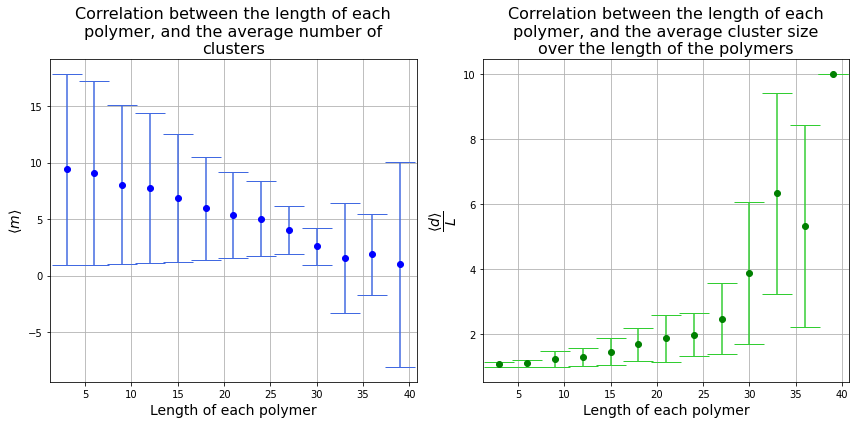

C:\Users\Tore\AppData\Local\Temp/ipykernel_16112/159952688.py:44: NumbaTypeSafetyWarning: unsafe cast from int64 to undefined. Precision may be lost.
  delta_E = move_polymer_medium_flexibility(result, N, T, polymer_list, poly_nr, move)


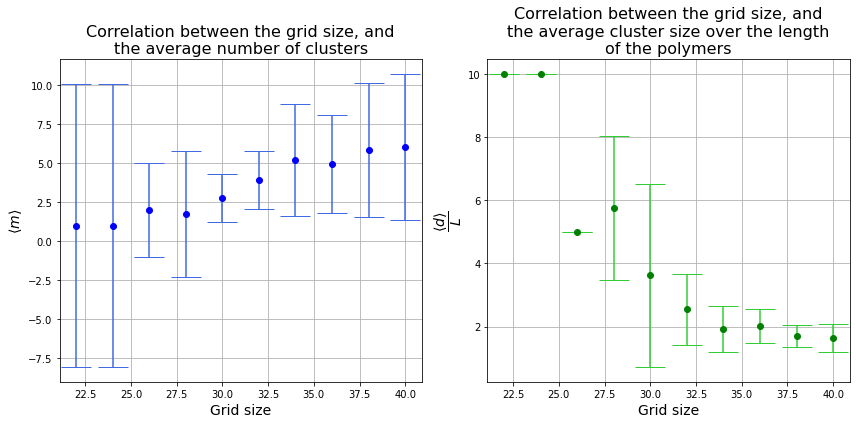

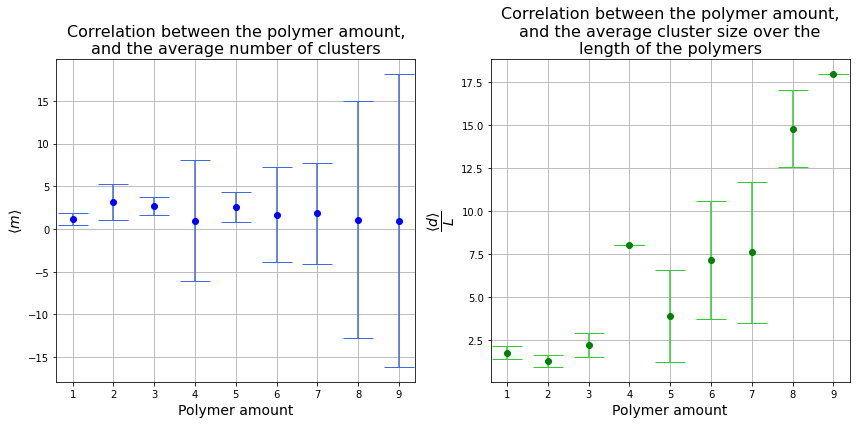

In [57]:
N = 30
M = 5
L = 30

L_nodes = np.linspace(L_low, L_high, 13, dtype=np.int64)
d_over_L_average_L, d_stddiv_L, m_average_L, m_stddiv_L = mean_cluster_size_and_number_over_L(N, M, L_nodes)
plot_d_over_L_and_m(L_nodes, d_over_L_average_L, d_stddiv_L, m_average_L, m_stddiv_L, "Length of each polymer")

N_nodes = np.arange(22, 40+1, 2)
d_over_L_average_N, d_stddiv_N, m_average_N, m_stddiv_N = mean_cluster_size_and_number_over_N(N_nodes, M, L)
plot_d_over_L_and_m(N_nodes, d_over_L_average_N, d_stddiv_N, m_average_N, m_stddiv_N, "Grid size")

M_nodes = np.arange(1, 10)
d_over_L_average_M, d_stddiv_M, m_average_M, m_stddiv_M = mean_cluster_size_and_number_over_M(N, M_nodes, L)
plot_d_over_L_and_m(M_nodes, d_over_L_average_M, d_stddiv_M, m_average_M, m_stddiv_M, "Polymer amount")


We will first discuss the t_equill function, which was heavly inspired by the t_equill function in 1h. The constants were chosen somewhat arbitrarily, were we tried multiple values, and ended up chosing values that gave decent results, without increasing the runtime too much. The exponent in the t_equill function were chosen such that it would increase or decrease when it made sense. For instance, an increase in the grid size should increase t_equill because the polymers have to move more to reach one another, an increased polymer count should decrease t_equill as more polymers decrease the average distance between polymers.

Now for the discussion of the graphs.
When looking at the Correlation between the length of each polymer, and the average cluster size over the length of the polymers, we see a declining trend, as expected. As the polymers become longer, using flexibility move, after using Monte Carlo, they are more likely to hit each other. This will lead to us getting fewer clusters.

When looking at the Correlation between the length of each polymer, and the average cluster size over the length of the polymers, we see an increasing trend, as expected. If L is small, each polymer will most likely not be in contact with other polymers. If we then divide by the length, it is expected to have a cluster size of one. If we increase L, the number of clusters will be smaller, as indicated by the descending graph, and at the same time the length of the clusters will be larger, as the polymers hit each other more. Thus we see a sharp increase in the graph at larger L.

The discussion above is based on the fact that we use medium flexibility move, but polymers can also move in another way, ie rigid move. Rigid move has stricter movement conditions than a medium flexibility move, and the results will of course be different.

If we look at the correlation between the length of each polymer, and the average cluster size over the length of the polymers, for small values of L it would not have been so much different from flexibility move, as the polymers come into little contact. If we let L get bigger, the polymers will probably come into more contact, but they will not be able to come into contact with as many polymers as flexibility move does. This will be a result of rigid move having stricter movement conditions. Flexibility move can still move after encountering a polymer, meaning that they can come into contact with more polymers and form larger clusters. If we encounter a polymer in rigid movement, we stop the possibility that the polymers that encountered come into contact with other polymers.Rigid move will then have a slower growth curve than flexibility move.

When it comes to Correlation between the length of each polymer, and the average number of clusters, it seems that we will also have a falling graph for rigid move, based on the argument above, but this graph will obviously fall much slower than the for flexibility move.

What if we choose to keep L constant? If we change N, by making it larger, the probability of clusters forming will decrease significantly, as there will be a greater distance between polymers. If we make N too small, we will get a large cluster. That is, a graph that falls to zero for large N. If M grows, the probability of clusters forming will increase. If M falls, we will have the opposite effect, and have smaller clusters. Thus increasing N may be considered equivalent with decreasing M, and vice versa.

# Conclusion:

Formation of membrane-free organelles is a far too complex process to analyze soley with analytical tools, it is therfor a necessity to use numerical methods to properly study these processes. In this project, we aimed to get a better understanding for these processes using mainly Monte Carlo simulations.

We initially chose to consider monomers, which may be thought of as a reduced version of the problem. For the monomer systems, we ran Monte Carlo for two different temperatures, 200K and 500K. We concluded that lower temperature systems aim towards order in the sense that they are efficient at reducing the systems total energy. We then analyzed the cluster formation of these systems, and we discovered that increasing the temperature leads to more spare clusters, in other words, lower energies take the form of fewer big clusters. This result fits well with our intuition that lower energy forms are more compact, and higher energy forms are more spread out, like the states of matter are a good example of. 

We then expanded our consideration over to premade clusters of monomers, known as polymers. We considered two different cases, one where the polymers moved merely rigidly, and one where they could also move in accordance with the medium flexibly movement function, which we deemed to be more realistic. We only considered these cases with a fixed temperature of 200K. Common results from a Monte Carlo simulation with these movement functions, were that the polymers tended to end up in configurations where oppositely charged polymers were adjacent to each other. This is as expected since such configuration lead to a minmum total energy, which the monomer case showed that lower temperatures, like 200K, would tend towards. 
Considering energy, the systems where the polymers have the ability to move flexibly tend towards a lower total energy than its rigid movement counterpart. We concluded that the reason for this, was because flexible moves providing greater opportunity to form intertwined polymer clusters. 
Considering cluster formation, it turns out that the longer the polymers, the fewer clusters you get. This makes sense, as the polymers are then more likely to come into contact. When looking at the Correlation between the length of each polymer, and the average cluster size over the length of the polymers, we see an increasing trend, as expected.
